In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from datetime import datetime, timedelta
import gc
import lightgbm as lgb

In [60]:
CAL_COL_TYPES = {'event_name_1':'category', 'event_type_1':'category','event_name_2':'category', 'event_type_2':'category', 
            'weekday':'category', 'wm_yr_wk': 'int16', 'wday': 'int16', 'month': 'int16', 'year':'int16', 
            'snap_CA': 'float32', 'snap_TX': 'float32', 'snap_WI':'float32'}
SELLP_COL_TYPES = {'store_id':'category', 'item_id': 'category', 'wm_yr_wk': 'int16', 'sell_price':'float32'}

In [61]:
# Read the data
cal_data=pd.read_csv('m5_data/calendar.csv', dtype=CAL_COL_TYPES)
sellp_data=pd.read_csv('m5_data/sell_prices.csv', dtype=SELLP_COL_TYPES)


In [62]:
print(cal_data.shape)
cal_data.head()

(1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0.0,0.0,0.0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1.0,1.0,0.0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1.0,0.0,1.0


In [63]:
cal_data.loc[1913:]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1913,2016-04-25,11613,Monday,3,4,2016,d_1914,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1914,2016-04-26,11613,Tuesday,4,4,2016,d_1915,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1915,2016-04-27,11613,Wednesday,5,4,2016,d_1916,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1916,2016-04-28,11613,Thursday,6,4,2016,d_1917,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1917,2016-04-29,11613,Friday,7,4,2016,d_1918,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1918,2016-04-30,11614,Saturday,1,4,2016,d_1919,Pesach End,Religious,NaN,NaN,0.0,0.0,0.0
1919,2016-05-01,11614,Sunday,2,5,2016,d_1920,OrthodoxEaster,Religious,NaN,NaN,1.0,1.0,0.0
1920,2016-05-02,11614,Monday,3,5,2016,d_1921,NaN,NaN,NaN,NaN,1.0,0.0,1.0
1921,2016-05-03,11614,Tuesday,4,5,2016,d_1922,NaN,NaN,NaN,NaN,1.0,1.0,1.0
1922,2016-05-04,11614,Wednesday,5,5,2016,d_1923,NaN,NaN,NaN,NaN,1.0,0.0,0.0


In [64]:
print(sellp_data.shape)
sellp_data.head()

(6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [65]:
max_lags = 57 # Number of days to look dack when predicting values
tr_last = 1913 # Last training date
fday = datetime(2016,4,25)
fday

datetime.datetime(2016, 4, 25, 0, 0)

In [66]:
sellp_data.dtypes

store_id      category
item_id       category
wm_yr_wk         int16
sell_price     float32
dtype: object

In [67]:
def create_df(is_train=True, nrows=None, first_day=1200):
    # convert categorical colum values to numerical for sell_prices.csv 
    sellp_data_change = sellp_data.copy()
    for col, col_dtype in SELLP_COL_TYPES.items():
        if col_dtype == 'category':
            sellp_data_change[col] = sellp_data_change[col].cat.codes.astype('int16')
            sellp_data_change[col] -= sellp_data_change[col].min()
    
    cal_data_change = cal_data.copy()
    cal_data_change['date'] = pd.to_datetime(cal_data_change['date'])
    # convert categorical colum values to numerical for calendar.csv
    for col, col_dtype in CAL_COL_TYPES.items():
        if col_dtype == 'category':
            cal_data_change[col] = cal_data_change[col].cat.codes.astype('int16')
            cal_data_change[col] -= cal_data_change[col].min()
            
    start_day = max(1 if is_train else tr_last-max_lags, first_day)
    dcols = [f'd_{day}' for day in range(start_day, tr_last+1)]
    catcols = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
    dtype = {dcol : 'float32' for dcol in dcols}
    dtype.update({col:'category' for col in catcols if col!='id'})
    salestv_data=pd.read_csv('m5_data/sales_train_validation.csv', nrows=nrows, usecols= catcols+dcols, dtype=dtype)
    
    # convert categorical colum values to numerical for sales_train_validation.csv 
    for col in catcols:
        if col != 'id':
            salestv_data[col] = salestv_data[col].cat.codes.astype('int16')
            salestv_data[col] -= salestv_data[col].min()
    
    if not is_train:
        for day in range(tr_last+1, tr_last+28+1):
            salestv_data[f'd_{day}'] = np.nan
    
    # Unpivot the datafame along d_cols
    df = pd.melt(salestv_data, 
                 id_vars=catcols, 
                 value_vars=[col for col in salestv_data.columns if col.startswith('d_')],
                 var_name='d',
                 value_name='sales'
                )
    df = df.merge(cal_data_change, on='d', copy=False)
    df = df.merge(sellp_data_change, on=['store_id', 'item_id', 'wm_yr_wk'], copy=False)
    return df        

In [68]:
%%time 

df_test = create_df()

CPU times: user 6.26 s, sys: 2.72 s, total: 8.98 s
Wall time: 9.86 s


In [69]:
df_test.shape

(21290801, 22)

In [70]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21290801 entries, 0 to 21290800
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   cat_id        int16         
 4   store_id      int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
dtypes: datetime64[ns](1), float32(5), int16(14), object(2)
memory us

In [71]:
df_test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1200,0.0,2014-05-12,11415,...,5,2014,0,0,0,0,0.0,1.0,1.0,8.26
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1201,0.0,2014-05-13,11415,...,5,2014,0,0,0,0,0.0,1.0,0.0,8.26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1202,0.0,2014-05-14,11415,...,5,2014,0,0,0,0,0.0,0.0,1.0,8.26
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1203,0.0,2014-05-15,11415,...,5,2014,0,0,0,0,0.0,1.0,1.0,8.26
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1204,0.0,2014-05-16,11415,...,5,2014,0,0,0,0,0.0,0.0,0.0,8.26


In [72]:
#del df_test

In [73]:
def create_fea(df):
    lags =[7, 28]
    lag_cols = [f'd_{lag}' for lag in lags]
    
    # shift the sales by lag value and append a new column
    for lag, lag_col in zip(lags, lag_cols):
        df[lag_col] = df[['id', 'sales']].groupby('id')['sales'].shift(lag)
        
    wins = [7, 28]
    for win in wins:
        for lag, lag_col in zip(lags, lag_cols):
            df[f'rmean_{lag}_{win}'] = df[['id', lag_col]].groupby('id')[lag_col].transform(lambda x: x.rolling(win).mean())
    
    date_features = {
        'wday':'weekday',
        'week':'weekofyear',
        'month':'month',
        'quarter':'quarter',
        'year':'year',
        'mday':'day'
    }
    
    # This code will add missing features of date in the dataframe & for the existing features it 
    # will change their type to int16
    for date_feature_name, date_feature_func in date_features.items():
        if date_feature_name in df.columns:
            df[date_feature_name] = df[date_feature_name].astype('int16')
        else:
            df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')

In [74]:
FIRST_DAY=1

In [75]:
sellp_data.dtypes

store_id      category
item_id       category
wm_yr_wk         int16
sell_price     float32
dtype: object

In [76]:
%%time

df = create_df(is_train=True, first_day = FIRST_DAY)
print(df.shape)

(46027957, 22)
CPU times: user 14.5 s, sys: 8.2 s, total: 22.7 s
Wall time: 26.3 s


In [77]:
%%time

create_fea(df)
print(df.shape)

/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


(46027957, 31)
CPU times: user 54.4 s, sys: 7.01 s, total: 1min 1s
Wall time: 1min 2s


In [78]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46027957 entries, 0 to 46027956
Data columns (total 31 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            object        
 1   item_id       int16         
 2   dept_id       int16         
 3   cat_id        int16         
 4   store_id      int16         
 5   state_id      int16         
 6   d             object        
 7   sales         float32       
 8   date          datetime64[ns]
 9   wm_yr_wk      int16         
 10  weekday       int16         
 11  wday          int16         
 12  month         int16         
 13  year          int16         
 14  event_name_1  int16         
 15  event_type_1  int16         
 16  event_name_2  int16         
 17  event_type_2  int16         
 18  snap_CA       float32       
 19  snap_TX       float32       
 20  snap_WI       float32       
 21  sell_price    float32       
 22  d_7           float32       
 23  d_28          float32       
 

In [79]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,d_7,d_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
0,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_1,12.0,2011-01-29,11101,...,0.46,NaN,NaN,NaN,NaN,NaN,NaN,4,1,29
1,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_2,15.0,2011-01-30,11101,...,0.46,NaN,NaN,NaN,NaN,NaN,NaN,4,1,30
2,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_3,0.0,2011-01-31,11101,...,0.46,NaN,NaN,NaN,NaN,NaN,NaN,5,1,31
3,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_4,0.0,2011-02-01,11101,...,0.46,NaN,NaN,NaN,NaN,NaN,NaN,5,1,1
4,HOBBIES_1_008_CA_1_validation,7,0,0,0,0,d_5,0.0,2011-02-02,11101,...,0.46,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2


In [80]:
# Drop missing value rows
df.dropna(inplace=True)
df.shape

(44351007, 31)

In [81]:
#del sellp_data, cal_data

In [82]:
cat_features = ['item_id', 'store_id', 'cat_id', 'dept_id', 'state_id'] + ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']
useless_cols = ['id', 'date', 'sales', 'd', 'wm_yr_wk', 'weekday']
train_cols = df.columns[~df.columns.isin(useless_cols)]
X_train = df[train_cols]
y_train = df['sales']

In [83]:
%%time

np.random.seed(777)

# This is a random sample, we're not gonna apply any time series train-test-split tricks here!
fake_valid_inds = np.random.choice(X_train.index.values, 2_000_000, replace=False) # Validation dataset
train_inds = np.setdiff1d(X_train.index.values, fake_valid_inds) # Training dataset

train_data = lgb.Dataset(X_train.loc[train_inds], label=y_train.loc[train_inds], categorical_feature=cat_features, free_raw_data=False)
fake_valid_data = lgb.Dataset(X_train.loc[fake_valid_inds], label=y_train.loc[fake_valid_inds], categorical_feature=cat_features, free_raw_data=False)

CPU times: user 6.89 s, sys: 3.52 s, total: 10.4 s
Wall time: 12 s


In [84]:
#del df, X_train, y_train, fake_valid_inds,train_inds ; gc.collect()

In [35]:
# LGB parameters

params={
#    'device':'gpu',
    'objective':'poisson',
    'metric':['rmse','mae'],
    'force_row_wise':True,
    'learning_rate':0.075,
    'sub_row': 0.75,
    'bagging_freq': 1,
    'lambda_12':0.1,
    'verbosity':1,
    'num_iterations':120,
    'num_leaves':2**11-1,
    'min_data_in_leaf':2**12-1
}

In [36]:
%%time

m_lgb = lgb.train(params, train_data, valid_sets=[fake_valid_data], verbose_eval=20)

/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/anaconda3/envs/py38forecasting/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Warning] Unknown parameter: lambda_12
[LightGBM] [Info] Total Bins 4602
[LightGBM] [Info] Number of data points in the train set: 42351007, number of used features: 25
[LightGBM] [Info] Start training from score 0.326013
[20]	valid_0's rmse: 2.85662
[40]	valid_0's rmse: 2.52881
[60]	valid_0's rmse: 2.43937
[80]	valid_0's rmse: 2.4102
[100]	valid_0's rmse: 2.39593
[120]	valid_0's rmse: 2.38405
CPU times: user 41min 35s, sys: 5min 5s, total: 46min 41s
Wall time: 8min 20s


In [37]:
m_lgb.save_model("model.lgb")

In [38]:
cal_data=pd.read_csv('m5_data/calendar.csv', dtype=CAL_COL_TYPES)
sellp_data=pd.read_csv('m5_data/sell_prices.csv', dtype=SELLP_COL_TYPES)

In [39]:
%%time

alphas = [1.028, 1.023, 1.018]
weights = [1/len(alphas)]*len(alphas)
sub = 0.

for icount, (alpha, weight) in enumerate(zip(alphas, weights)):

    # create a dataframe that has values starting from tr_last-max_lags (1913 - 57) i.e, 57 days 
    # before the start of validation date
    te = create_df(False)
    cols = [f"F{i}" for i in range(1,29)]

    for tdelta in range(0, 28):
        day = fday + timedelta(days=tdelta)
        print(tdelta, day)
        # Create a dataframe starting from day to it's previous 57 days
        tst = te[(te.date >= day - timedelta(days=max_lags)) & (te.date <= day)].copy()
        create_fea(tst)
        # Make tst exactly the same format as used for training for model to predict values
        tst = tst.loc[tst.date == day , train_cols]
        # Add the predicted values of sales to the dataframe starting from firstday of validation
        te.loc[te.date == day, "sales"] = alpha*m_lgb.predict(tst) # magic multiplier by kyakovlev


    # Select and create a sub-df starting from validation day
    te_sub = te.loc[te.date >= fday, ["id", "sales"]].copy()
    
    # Number each item in each group from 0 to the length of that group - 1: cumcount()
    te_sub["F"] = [f"F{rank}" for rank in te_sub.groupby("id")["id"].cumcount()+1]
    
    # Unstack or pivot the values back to their original shape as per submission.csv
    te_sub = te_sub.set_index(["id", "F" ]).unstack()["sales"][cols].reset_index()
    
    #Replace all the Nan values to 0
    te_sub.fillna(0., inplace = True)
    
    te_sub.sort_values("id", inplace = True)
    te_sub.reset_index(drop=True, inplace = True)
    te_sub.to_csv(f"submission_{icount}.csv",index=False)
    # Create the weigted average value of sales
    if icount == 0 :
        sub = te_sub
        sub[cols] *= weight
    else:
        sub[cols] += te_sub[cols]*weight
    print(icount, alpha, weight)


sub2 = sub.copy()
sub2["id"] = sub2["id"].str.replace("validation$", "evaluation")
sub = pd.concat([sub, sub2], axis=0, sort=False)
sub.to_csv("submission.csv",index=False)

0 2016-04-25 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


1 2016-04-26 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


2 2016-04-27 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


3 2016-04-28 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


4 2016-04-29 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


5 2016-04-30 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


6 2016-05-01 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


7 2016-05-02 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


8 2016-05-03 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


9 2016-05-04 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


10 2016-05-05 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


11 2016-05-06 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


12 2016-05-07 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


13 2016-05-08 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


14 2016-05-09 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


15 2016-05-10 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


16 2016-05-11 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


17 2016-05-12 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


18 2016-05-13 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


19 2016-05-14 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


20 2016-05-15 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


21 2016-05-16 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


22 2016-05-17 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


23 2016-05-18 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


24 2016-05-19 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


25 2016-05-20 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


26 2016-05-21 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


27 2016-05-22 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


0 1.028 0.3333333333333333
0 2016-04-25 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


1 2016-04-26 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


2 2016-04-27 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


3 2016-04-28 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


4 2016-04-29 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


5 2016-04-30 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


6 2016-05-01 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


7 2016-05-02 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


8 2016-05-03 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


9 2016-05-04 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


10 2016-05-05 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


11 2016-05-06 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


12 2016-05-07 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


13 2016-05-08 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


14 2016-05-09 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


15 2016-05-10 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


16 2016-05-11 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


17 2016-05-12 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


18 2016-05-13 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


19 2016-05-14 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


20 2016-05-15 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


21 2016-05-16 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


22 2016-05-17 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


23 2016-05-18 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


24 2016-05-19 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


25 2016-05-20 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


26 2016-05-21 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


27 2016-05-22 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


1 1.023 0.3333333333333333
0 2016-04-25 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


1 2016-04-26 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


2 2016-04-27 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


3 2016-04-28 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


4 2016-04-29 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


5 2016-04-30 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


6 2016-05-01 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


7 2016-05-02 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


8 2016-05-03 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


9 2016-05-04 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


10 2016-05-05 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


11 2016-05-06 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


12 2016-05-07 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


13 2016-05-08 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


14 2016-05-09 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


15 2016-05-10 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


16 2016-05-11 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


17 2016-05-12 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


18 2016-05-13 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


19 2016-05-14 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


20 2016-05-15 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


21 2016-05-16 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


22 2016-05-17 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


23 2016-05-18 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


24 2016-05-19 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


25 2016-05-20 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


26 2016-05-21 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


27 2016-05-22 00:00:00


/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:29: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df[date_feature_name] = getattr(df['date'].dt, date_feature_func).astype('int16')


2 1.018 0.3333333333333333


<timed exec>:49: FutureWarning: The default value of regex will change from True to False in a future version.


CPU times: user 19min 5s, sys: 58.6 s, total: 20min 3s
Wall time: 1h 8min 15s


# Understanding the prediction value step-by-step

In [40]:
tst

,item_id,dept_id,cat_id,store_id,state_id,wday,month,year,event_name_1,event_type_1,...,sell_price,d_7,d_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
2561161,0,0,0,0,0,2,5,2016,0,0,...,8.38,1.194543,1.0,1.031328,1.142857,1.030593,0.964286,20,2,22
2561163,1,0,0,0,0,2,5,2016,0,0,...,3.97,0.286346,0.0,0.229299,0.142857,0.211305,0.071429,20,2,22
2561165,2,0,0,0,0,2,5,2016,0,0,...,2.97,0.851341,1.0,0.640854,0.857143,0.658713,0.571429,20,2,22
2561167,3,0,0,0,0,2,5,2016,0,0,...,4.64,3.267524,2.0,2.199713,2.571429,2.205576,1.821429,20,2,22
2561169,4,0,0,0,0,2,5,2016,0,0,...,2.88,1.382729,4.0,1.172626,1.714286,1.307560,1.357143,20,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2622131,3044,6,2,9,2,2,5,2016,0,0,...,2.98,0.588533,1.0,0.475221,0.285714,0.398317,0.214286,20,2,22
2622133,3045,6,2,9,2,2,5,2016,0,0,...,2.48,0.453827,0.0,0.370368,0.142857,0.304181,0.321429,20,2,22
2622135,3046,6,2,9,2,2,5,2016,0,0,...,3.98,1.217356,0.0,1.027705,0.571429,0.860745,0.892857,20,2,22
2622137,3047,6,2,9,2,2,5,2016,0,0,...,1.28,1.363977,3.0,1.174601,1.142857,1.087068,0.928571,20,2,22


In [41]:
pp = te[(te.date >= (fday - timedelta(days=max_lags))) & (te.date <= fday)]
pp

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1857,2.000000,2016-02-28,11605,...,2,2016,0,0,0,0,0.0,0.0,0.0,8.26
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1858,0.000000,2016-02-29,11605,...,2,2016,0,0,0,0,0.0,0.0,0.0,8.26
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1859,2.000000,2016-03-01,11605,...,3,2016,0,0,0,0,1.0,1.0,0.0,8.26
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1860,0.000000,2016-03-02,11605,...,3,2016,0,0,0,0,1.0,0.0,1.0,8.26
5,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1861,1.000000,2016-03-03,11605,...,3,2016,0,0,0,0,1.0,1.0,1.0,8.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920857,FOODS_3_826_WI_3_validation,3047,6,2,9,2,d_1913,3.000000,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
1920858,FOODS_3_826_WI_3_validation,3047,6,2,9,2,d_1914,0.912350,2016-04-25,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.28
1920863,FOODS_3_827_WI_3_validation,3048,6,2,9,2,d_1912,0.000000,2016-04-23,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.00
1920864,FOODS_3_827_WI_3_validation,3048,6,2,9,2,d_1913,0.000000,2016-04-24,11613,...,4,2016,0,0,0,0,0.0,0.0,0.0,1.00


In [42]:
create_fea(pp)

/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lag_col] = df[['id', 'sales']].groupby('id')['sales'].shift(lag)
/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[lag_col] = df[['id', 'sales']].groupby('id')['sales'].shift(lag)
/var/folders/h2/nzdrmmqs66x13b1h4f0882fh0000gn/T/ipykernel_9844/2805995247.py:12: SettingWithCopyWarning: 
A value is tryi

In [43]:
pp

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,sell_price,d_7,d_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
1,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1857,2.000000,2016-02-28,11605,...,8.26,NaN,NaN,NaN,NaN,NaN,NaN,8,1,28
2,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1858,0.000000,2016-02-29,11605,...,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,29
3,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1859,2.000000,2016-03-01,11605,...,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,1
4,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1860,0.000000,2016-03-02,11605,...,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,2
5,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,d_1861,1.000000,2016-03-03,11605,...,8.26,NaN,NaN,NaN,NaN,NaN,NaN,9,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920857,FOODS_3_826_WI_3_validation,3047,6,2,9,2,d_1913,3.000000,2016-04-24,11613,...,1.28,1.0,4.0,0.714286,1.571429,1.035714,1.250000,16,2,24
1920858,FOODS_3_826_WI_3_validation,3047,6,2,9,2,d_1914,0.912350,2016-04-25,11613,...,1.28,0.0,3.0,0.714286,1.857143,1.000000,1.285714,17,2,25
1920863,FOODS_3_827_WI_3_validation,3048,6,2,9,2,d_1912,0.000000,2016-04-23,11613,...,1.00,0.0,0.0,0.000000,2.285714,1.821429,1.785714,16,2,23
1920864,FOODS_3_827_WI_3_validation,3048,6,2,9,2,d_1913,0.000000,2016-04-24,11613,...,1.00,0.0,5.0,0.000000,2.428571,1.678571,1.964286,16,2,24


In [44]:
pp.loc[pp.date==fday, train_cols]

,item_id,dept_id,cat_id,store_id,state_id,wday,month,year,event_name_1,event_type_1,...,sell_price,d_7,d_28,rmean_7_7,rmean_28_7,rmean_7_28,rmean_28_28,week,quarter,mday
1707442,0,0,0,0,0,3,4,2016,0,0,...,8.38,1.0,1.0,0.857143,1.142857,0.964286,1.035714,17,2,25
1707449,1,0,0,0,0,3,4,2016,0,0,...,3.97,0.0,1.0,0.000000,0.714286,0.178571,0.357143,17,2,25
1707456,2,0,0,0,0,3,4,2016,0,0,...,2.97,1.0,0.0,1.285714,0.285714,0.464286,0.535714,17,2,25
1707463,3,0,0,0,0,3,4,2016,0,0,...,4.64,4.0,0.0,1.857143,3.000000,2.071429,1.892857,17,2,25
1707470,4,0,0,0,0,3,4,2016,0,0,...,2.88,0.0,1.0,0.857143,0.714286,1.071429,1.107143,17,2,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920837,3044,6,2,9,2,3,4,2016,0,0,...,2.98,0.0,0.0,0.285714,0.000000,0.142857,0.250000,17,2,25
1920844,3045,6,2,9,2,3,4,2016,0,0,...,2.48,0.0,0.0,0.142857,0.000000,0.285714,0.000000,17,2,25
1920851,3046,6,2,9,2,3,4,2016,0,0,...,3.98,2.0,1.0,0.714286,0.571429,0.928571,1.250000,17,2,25
1920858,3047,6,2,9,2,3,4,2016,0,0,...,1.28,0.0,3.0,0.714286,1.857143,1.000000,1.285714,17,2,25


In [45]:
%%time
pred = m_lgb.predict(tst)

CPU times: user 1.23 s, sys: 27.9 ms, total: 1.26 s
Wall time: 180 ms


In [46]:
pred.shape

(30490,)

In [47]:
te.loc[te.date==fday, 'sales'].shape

(30490,)

In [48]:
sub = te.loc[te.date >= fday, ["id", "sales"]]

In [49]:
sub["F"] = [f"F{rank}" for rank in sub.groupby("id")["id"].cumcount()+1]
sub = sub.set_index(['id','F'])
sub

sales
id                            F            
HOBBIES_1_001_CA_1_validation F1   0.857668
                              F2   0.762370
                              F3   0.799108
                              F4   0.849728
                              F5   0.933072
...                                     ...
FOODS_3_825_WI_3_validation   F28  0.902916
FOODS_3_826_WI_3_validation   F27  1.041003
                              F28  1.043642
FOODS_3_827_WI_3_validation   F27  1.433442
                              F28  1.418816

[853720 rows x 1 columns]

In [50]:
sub = sub.unstack()['sales'][cols].reset_index()
sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.955731,0.868901,0.864142,0.857659,1.114630,1.230089,1.149493,1.040928,0.968138,...,1.033170,1.299645,1.194888,0.932937,0.834751,0.820816,0.828073,1.004827,1.237144,1.220726
1,FOODS_1_001_CA_2_validation,0.964195,0.942240,0.921909,1.203369,1.077431,1.383807,1.456426,0.977796,0.941501,...,1.212465,1.522011,1.585957,1.110602,1.056663,1.032656,1.114086,1.283519,1.663396,1.399096
2,FOODS_1_001_CA_3_validation,1.095321,0.978656,0.984905,0.967928,1.036765,1.154278,0.989918,0.971947,0.926395,...,1.056171,1.273366,1.282697,1.036621,0.947158,0.947994,0.938693,1.071079,1.236129,1.086770
3,FOODS_1_001_CA_4_validation,0.441816,0.404927,0.388654,0.388654,0.419868,0.521572,0.546329,0.430288,0.435872,...,0.418617,0.453463,0.447340,0.420385,0.394412,0.391643,0.409286,0.421395,0.481215,0.483067
4,FOODS_1_001_TX_1_validation,0.182180,0.178490,0.171704,0.171704,0.216988,0.241981,0.264074,0.692404,0.695549,...,0.416127,0.446364,0.414745,0.346343,0.325858,0.320030,0.290796,0.320114,0.385231,0.413220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.276878,0.235909,0.289222,0.264029,0.290243,0.367885,0.363130,0.294525,0.307853,...,0.307727,0.404492,0.404700,0.285578,0.271215,0.284117,0.275344,0.300484,0.371818,0.355655
30486,HOUSEHOLD_2_516_TX_3_validation,0.164707,0.159566,0.172869,0.157916,0.185051,0.210427,0.199779,0.139201,0.138368,...,0.177629,0.225628,0.221963,0.172319,0.171817,0.171817,0.171817,0.195280,0.221363,0.222770
30487,HOUSEHOLD_2_516_WI_1_validation,0.099328,0.099328,0.099328,0.099328,0.106752,0.142306,0.140593,0.116572,0.116572,...,0.137779,0.177948,0.174716,0.110876,0.110876,0.110876,0.110876,0.140232,0.183573,0.179903
30488,HOUSEHOLD_2_516_WI_2_validation,0.062771,0.062771,0.062771,0.098534,0.103118,0.116638,0.116141,0.099551,0.099551,...,0.143039,0.161309,0.150098,0.110599,0.110599,0.110599,0.103631,0.115643,0.146628,0.144391


In [51]:
sub = sub.fillna(0.)
sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.955731,0.868901,0.864142,0.857659,1.114630,1.230089,1.149493,1.040928,0.968138,...,1.033170,1.299645,1.194888,0.932937,0.834751,0.820816,0.828073,1.004827,1.237144,1.220726
1,FOODS_1_001_CA_2_validation,0.964195,0.942240,0.921909,1.203369,1.077431,1.383807,1.456426,0.977796,0.941501,...,1.212465,1.522011,1.585957,1.110602,1.056663,1.032656,1.114086,1.283519,1.663396,1.399096
2,FOODS_1_001_CA_3_validation,1.095321,0.978656,0.984905,0.967928,1.036765,1.154278,0.989918,0.971947,0.926395,...,1.056171,1.273366,1.282697,1.036621,0.947158,0.947994,0.938693,1.071079,1.236129,1.086770
3,FOODS_1_001_CA_4_validation,0.441816,0.404927,0.388654,0.388654,0.419868,0.521572,0.546329,0.430288,0.435872,...,0.418617,0.453463,0.447340,0.420385,0.394412,0.391643,0.409286,0.421395,0.481215,0.483067
4,FOODS_1_001_TX_1_validation,0.182180,0.178490,0.171704,0.171704,0.216988,0.241981,0.264074,0.692404,0.695549,...,0.416127,0.446364,0.414745,0.346343,0.325858,0.320030,0.290796,0.320114,0.385231,0.413220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.276878,0.235909,0.289222,0.264029,0.290243,0.367885,0.363130,0.294525,0.307853,...,0.307727,0.404492,0.404700,0.285578,0.271215,0.284117,0.275344,0.300484,0.371818,0.355655
30486,HOUSEHOLD_2_516_TX_3_validation,0.164707,0.159566,0.172869,0.157916,0.185051,0.210427,0.199779,0.139201,0.138368,...,0.177629,0.225628,0.221963,0.172319,0.171817,0.171817,0.171817,0.195280,0.221363,0.222770
30487,HOUSEHOLD_2_516_WI_1_validation,0.099328,0.099328,0.099328,0.099328,0.106752,0.142306,0.140593,0.116572,0.116572,...,0.137779,0.177948,0.174716,0.110876,0.110876,0.110876,0.110876,0.140232,0.183573,0.179903
30488,HOUSEHOLD_2_516_WI_2_validation,0.062771,0.062771,0.062771,0.098534,0.103118,0.116638,0.116141,0.099551,0.099551,...,0.143039,0.161309,0.150098,0.110599,0.110599,0.110599,0.103631,0.115643,0.146628,0.144391


In [52]:
sub = sub.sort_values('id')
sub

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.955731,0.868901,0.864142,0.857659,1.114630,1.230089,1.149493,1.040928,0.968138,...,1.033170,1.299645,1.194888,0.932937,0.834751,0.820816,0.828073,1.004827,1.237144,1.220726
1,FOODS_1_001_CA_2_validation,0.964195,0.942240,0.921909,1.203369,1.077431,1.383807,1.456426,0.977796,0.941501,...,1.212465,1.522011,1.585957,1.110602,1.056663,1.032656,1.114086,1.283519,1.663396,1.399096
2,FOODS_1_001_CA_3_validation,1.095321,0.978656,0.984905,0.967928,1.036765,1.154278,0.989918,0.971947,0.926395,...,1.056171,1.273366,1.282697,1.036621,0.947158,0.947994,0.938693,1.071079,1.236129,1.086770
3,FOODS_1_001_CA_4_validation,0.441816,0.404927,0.388654,0.388654,0.419868,0.521572,0.546329,0.430288,0.435872,...,0.418617,0.453463,0.447340,0.420385,0.394412,0.391643,0.409286,0.421395,0.481215,0.483067
4,FOODS_1_001_TX_1_validation,0.182180,0.178490,0.171704,0.171704,0.216988,0.241981,0.264074,0.692404,0.695549,...,0.416127,0.446364,0.414745,0.346343,0.325858,0.320030,0.290796,0.320114,0.385231,0.413220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.276878,0.235909,0.289222,0.264029,0.290243,0.367885,0.363130,0.294525,0.307853,...,0.307727,0.404492,0.404700,0.285578,0.271215,0.284117,0.275344,0.300484,0.371818,0.355655
30486,HOUSEHOLD_2_516_TX_3_validation,0.164707,0.159566,0.172869,0.157916,0.185051,0.210427,0.199779,0.139201,0.138368,...,0.177629,0.225628,0.221963,0.172319,0.171817,0.171817,0.171817,0.195280,0.221363,0.222770
30487,HOUSEHOLD_2_516_WI_1_validation,0.099328,0.099328,0.099328,0.099328,0.106752,0.142306,0.140593,0.116572,0.116572,...,0.137779,0.177948,0.174716,0.110876,0.110876,0.110876,0.110876,0.140232,0.183573,0.179903
30488,HOUSEHOLD_2_516_WI_2_validation,0.062771,0.062771,0.062771,0.098534,0.103118,0.116638,0.116141,0.099551,0.099551,...,0.143039,0.161309,0.150098,0.110599,0.110599,0.110599,0.103631,0.115643,0.146628,0.144391


In [53]:
sub.reset_index(drop=True)

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.955731,0.868901,0.864142,0.857659,1.114630,1.230089,1.149493,1.040928,0.968138,...,1.033170,1.299645,1.194888,0.932937,0.834751,0.820816,0.828073,1.004827,1.237144,1.220726
1,FOODS_1_001_CA_2_validation,0.964195,0.942240,0.921909,1.203369,1.077431,1.383807,1.456426,0.977796,0.941501,...,1.212465,1.522011,1.585957,1.110602,1.056663,1.032656,1.114086,1.283519,1.663396,1.399096
2,FOODS_1_001_CA_3_validation,1.095321,0.978656,0.984905,0.967928,1.036765,1.154278,0.989918,0.971947,0.926395,...,1.056171,1.273366,1.282697,1.036621,0.947158,0.947994,0.938693,1.071079,1.236129,1.086770
3,FOODS_1_001_CA_4_validation,0.441816,0.404927,0.388654,0.388654,0.419868,0.521572,0.546329,0.430288,0.435872,...,0.418617,0.453463,0.447340,0.420385,0.394412,0.391643,0.409286,0.421395,0.481215,0.483067
4,FOODS_1_001_TX_1_validation,0.182180,0.178490,0.171704,0.171704,0.216988,0.241981,0.264074,0.692404,0.695549,...,0.416127,0.446364,0.414745,0.346343,0.325858,0.320030,0.290796,0.320114,0.385231,0.413220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2_validation,0.276878,0.235909,0.289222,0.264029,0.290243,0.367885,0.363130,0.294525,0.307853,...,0.307727,0.404492,0.404700,0.285578,0.271215,0.284117,0.275344,0.300484,0.371818,0.355655
30486,HOUSEHOLD_2_516_TX_3_validation,0.164707,0.159566,0.172869,0.157916,0.185051,0.210427,0.199779,0.139201,0.138368,...,0.177629,0.225628,0.221963,0.172319,0.171817,0.171817,0.171817,0.195280,0.221363,0.222770
30487,HOUSEHOLD_2_516_WI_1_validation,0.099328,0.099328,0.099328,0.099328,0.106752,0.142306,0.140593,0.116572,0.116572,...,0.137779,0.177948,0.174716,0.110876,0.110876,0.110876,0.110876,0.140232,0.183573,0.179903
30488,HOUSEHOLD_2_516_WI_2_validation,0.062771,0.062771,0.062771,0.098534,0.103118,0.116638,0.116141,0.099551,0.099551,...,0.143039,0.161309,0.150098,0.110599,0.110599,0.110599,0.103631,0.115643,0.146628,0.144391


In [54]:
salestv_data=pd.read_csv('m5_data/sales_train_validation.csv')

In [55]:
salestv_data.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
30489,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
cal_data.tail(56)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1913,2016-04-25,11613,Monday,3,4,2016,d_1914,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1914,2016-04-26,11613,Tuesday,4,4,2016,d_1915,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1915,2016-04-27,11613,Wednesday,5,4,2016,d_1916,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1916,2016-04-28,11613,Thursday,6,4,2016,d_1917,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1917,2016-04-29,11613,Friday,7,4,2016,d_1918,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1918,2016-04-30,11614,Saturday,1,4,2016,d_1919,Pesach End,Religious,NaN,NaN,0.0,0.0,0.0
1919,2016-05-01,11614,Sunday,2,5,2016,d_1920,OrthodoxEaster,Religious,NaN,NaN,1.0,1.0,0.0
1920,2016-05-02,11614,Monday,3,5,2016,d_1921,NaN,NaN,NaN,NaN,1.0,0.0,1.0
1921,2016-05-03,11614,Tuesday,4,5,2016,d_1922,NaN,NaN,NaN,NaN,1.0,1.0,1.0
1922,2016-05-04,11614,Wednesday,5,5,2016,d_1923,NaN,NaN,NaN,NaN,1.0,0.0,0.0


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importance(),'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

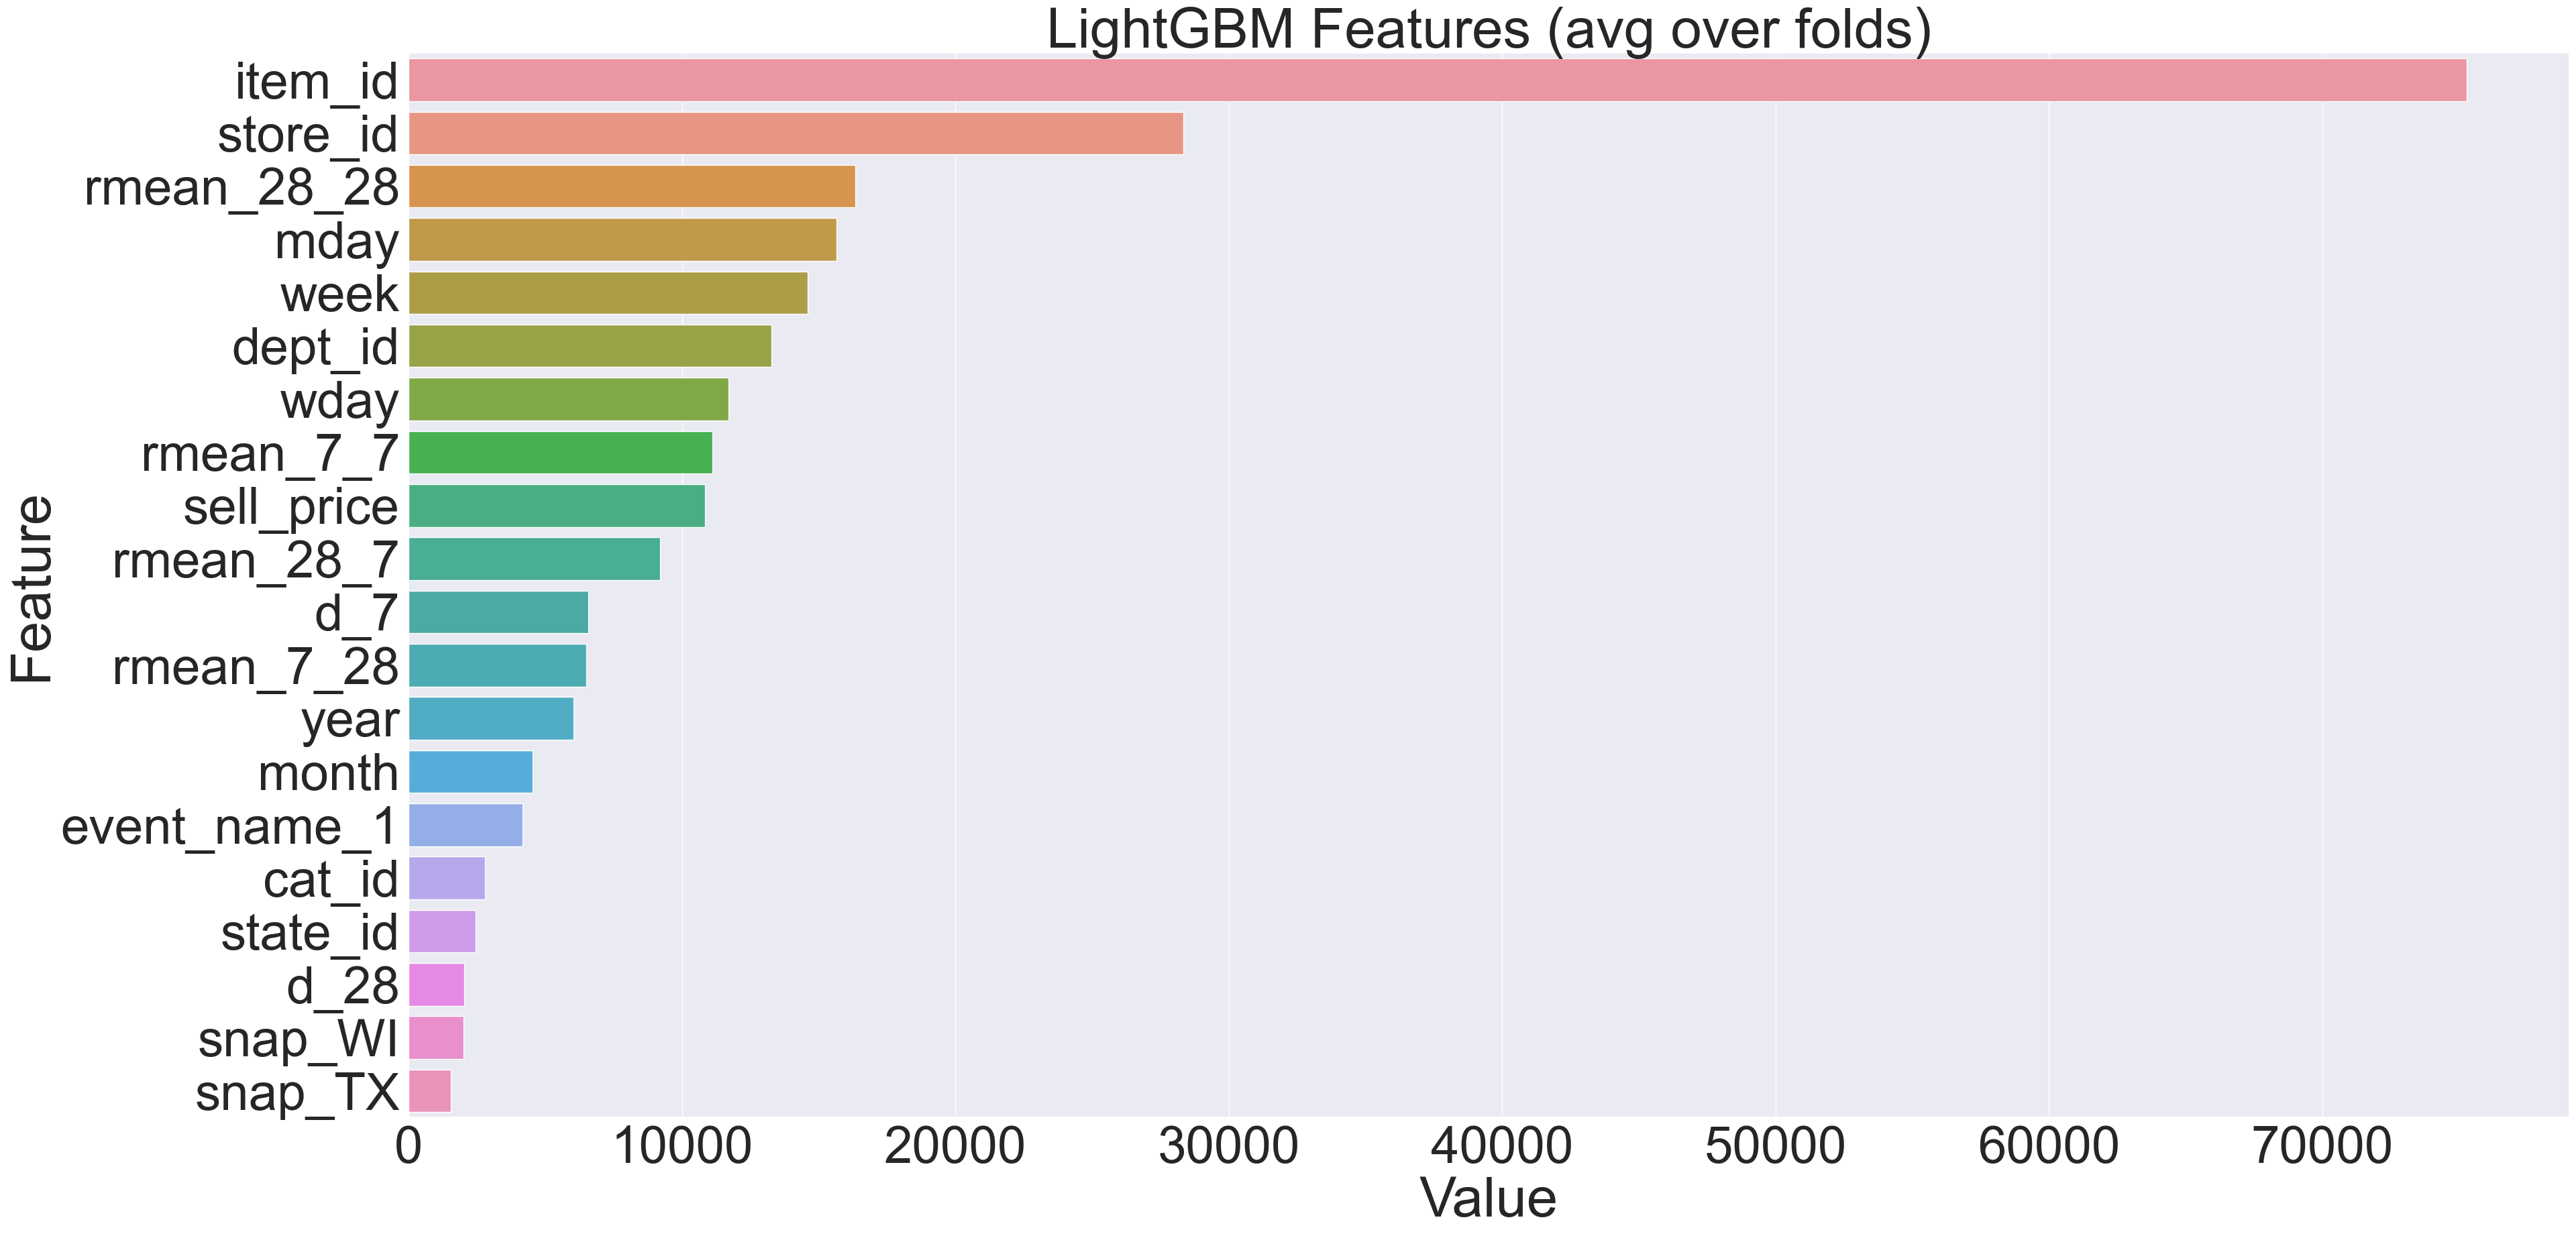

In [ ]:
plotImp(m_lgb, X_train)

The light GBM model performed fairly well with an RMSE over the folds is approximately 2.3. I can see from the relative feature importance that the top 3 features were item_id, store_id, sell_price, and week. I think item_id and sell_price makes sense to be the top features for the forecast because the forecast will depend on the items and price of the items. Week also makes sense because the forecast depends on time parameters to make a forecast, so having a time parameter in the top three relative important features is logical.